# Visualise Coco

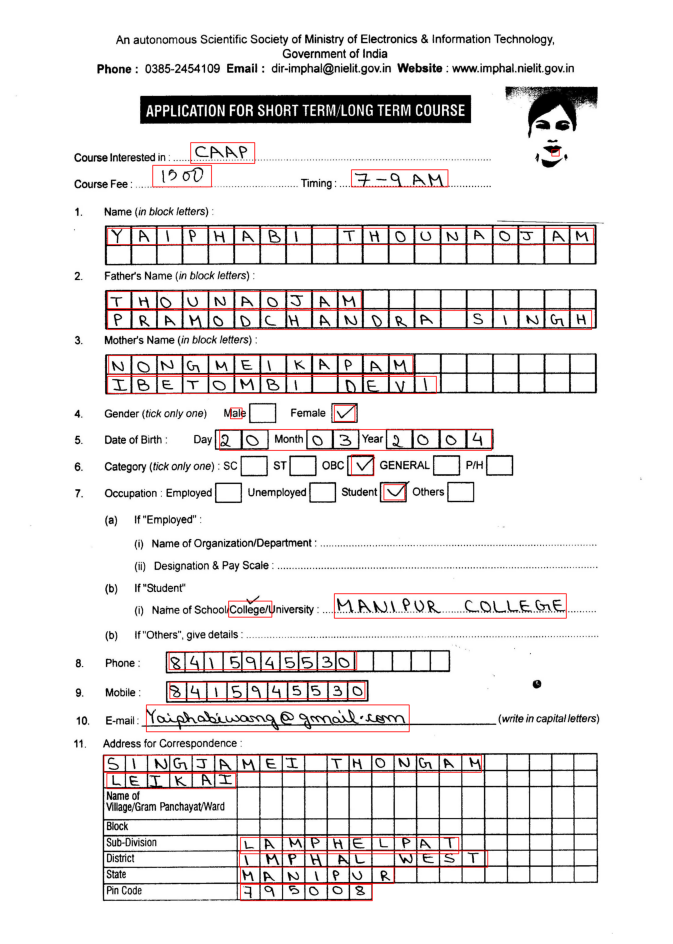

In [17]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize the annotations for a single image
def visualize_single_image(json_file, image_folder, image_filename):
    # Load the COCO JSON data
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    # Find the image ID corresponding to the image_filename
    image_info = None
    for img in coco_data['images']:
        if img['file_name'] == image_filename:
            image_info = img
            break
    
    if image_info is None:
        print(f"Image {image_filename} not found in JSON file.")
        return

    image_id = image_info['id']
    
    # Load the image
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Failed to load image {image_filename}.")
        return

    # Find all annotations for this image
    polygons = []
    for ann in coco_data['annotations']:
        if ann['image_id'] == image_id:
            bbox = ann['bbox']  # [x_min, y_min, width, height]
            
            # Convert bbox to polygon (COCO bbox is [x_min, y_min, width, height])
            x_min, y_min, width, height = bbox
            x_max, y_max = x_min + width, y_min + height
            polygon = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
            polygons.append(polygon)

    # Draw the polygons on the image
    for polygon in polygons:
        polygon_np = np.array(polygon, np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [polygon_np], isClosed=True, color = (0, 0, 255), thickness=2)
    
    # Convert the image from BGR (OpenCV format) to RGB (for Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the annotated image
    plt.figure(figsize=(20, 12))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage in a Jupyter Notebook:
json_file = 'files/input/box_merged_coco.json'
image_folder = 'files/input'
image_filename = '1.jpg'
visualize_single_image(json_file, image_folder, image_filename)


# Full

In [10]:
import json
from modules import detector, bbox_merger, recognizer, layloutlm

def load_models():
    detector_model_file = "checkpoints/FAST/fast_base_20240926-134200_epoch100.pt"
    recognizer_model_path = "checkpoints/TrOCR"
    layoutlm_model_path = "checkpoints/LayoutLM"

    trained_detector, default_detector = detector.load_detector(detector_model_file)
    trocr_processor, trocr_model, device = recognizer.load_recognizer(recognizer_model_path)
    llm_model, llm_processor = layloutlm.load_layoutlm(layoutlm_model_path)

    detector_models = [trained_detector, default_detector]
    recognizer_models = [trocr_processor, trocr_model, device]
    layoutlm_models = [llm_model, llm_processor]

    models = [detector_models, recognizer_models, layoutlm_models]
    return models

def process_image(image_path, models):

    detector_models = models[0]
    recogniser_models = models[1]
    layoutlm_models = models[2]


# 1. Detect words
    doctr_coco, doctr_result = detector.detect_words(image_path, detector_models, model="trained")

    with open('files/input/doctr_result.txt', 'w') as f:
        f.write(str(doctr_result))
    with open("files/input/doctr_coco.json", "w") as file:
        json.dump(doctr_coco, file)


 # 2. Merge bounding boxes
    box_merged_coco = bbox_merger.merge_annotations(doctr_coco)
    doctr_coco["annotations"] = box_merged_coco

    with open("files/input/box_merged_coco.json", "w") as file:
        json.dump(doctr_coco, file)


# 3. Recognize text
    trocr_result, trocr_coco = recognizer.recognize_text(doctr_coco, image_path, recogniser_models)

    with open("files/input/trocr_result.json", "w") as file:
        json.dump(trocr_result, file)
    with open("files/input/trocr_coco.json", "w") as file:
        json.dump(trocr_coco, file)


 # 4. Recognise Layout
    layoutlm_result = layloutlm.assign_tag(trocr_coco, image_path, layoutlm_models)

    return layoutlm_result

models = load_models()


In [ ]:
image_path = "files/input/1.jpg"

layoutlm_result = process_image(image_path, models)
layoutlm_result

with open("files/input/final_result.json", "w") as file:
    json.dump(layoutlm_result, file)

# Sectional

In [ ]:
import json
from modules import detector, bbox_merger, recognizer, layloutlm
from typing import Dict

def load_models():
    detector_model_file = "checkpoints/FAST/fast_base_20240926-134200_epoch100.pt"
    recognizer_model_path = "checkpoints/TrOCR"
    layoutlm_model_path = "checkpoints/LayoutLM"

    trained_detector, default_detector = detector.load_detector(detector_model_file)
    trocr_processor, trocr_model, device = recognizer.load_recognizer(recognizer_model_path)
    llm_model, llm_processor = layloutlm.load_layoutlm(layoutlm_model_path)

    detector_models = [trained_detector, default_detector]
    recognizer_models = [trocr_processor, trocr_model, device]
    layoutlm_models = [llm_model, llm_processor]

    models = [detector_models, recognizer_models, layoutlm_models]
    return models

models = load_models()

In [3]:
image_path = "files/input/1.jpg"

detector_models = models[0]
recogniser_models = models[1]
layoutlm_models = models[2]

In [ ]:
# 1. Detect words
doctr_coco, doctr_result = detector.detect_words(image_path, detector_models, model="trained")
doctr_coco

In [ ]:
# 2. Merge bounding boxes
box_merged_coco = bbox_merger.merge_annotations(doctr_coco)
doctr_coco["annotations"] = box_merged_coco
doctr_coco

In [ ]:
# 3. Recognize text
trocr_result, trocr_coco = recognizer.recognize_text(doctr_coco, image_path, recogniser_models)
trocr_result

In [ ]:
# 4. Recognise Layout
layoutlm_result = layloutlm.assign_tag(trocr_coco, image_path, layoutlm_models)
layoutlm_result

In [ ]:
# # (Optional) Example usage if you run main.py directly
# if __name__ == "__main__":
#     image_path = "files/input/1.jpg"

#     models = load_models()

#     layoutlm_result = process_image(image_path, models)
#     print(layoutlm_result)

#     with open("files/input/final_result.json", "w") as file:
#         json.dump(layoutlm_result, file)